In [1]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees

In [2]:
df_orig = pd.read_excel('default_of_credit_card_clients.xls')

In [3]:
df_zero_mask = df_orig == 0

In [4]:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

In [5]:
sum(feature_zero_mask)

315

In [6]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
df_clean.shape

(29685, 25)

In [7]:
df_clean['ID'].nunique()

29685

In [8]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)

In [9]:
df_clean['PAY_1'].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [10]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'

In [11]:
sum(missing_pay_1_mask)

3021

In [12]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()

In [13]:
df = pd.read_csv('cleaned_data.csv')

In [14]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [15]:
features_response = df.columns.tolist()

In [16]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [17]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,test_size=0.2, random_state=24)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [21]:
features_response[4]

'PAY_1'

In [22]:
np.median(X_train[:,4])

0.0

In [23]:
np.random.seed(seed=1)
fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]

In [24]:
fill_strategy = ['mode', 'random']

In [25]:
fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)

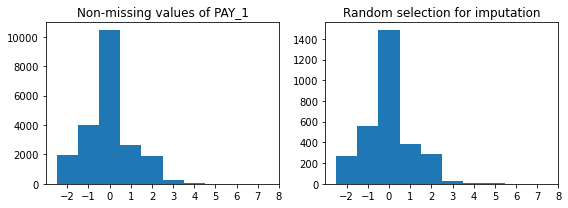

In [26]:
import matplotlib.pyplot as plt #plotting package
%matplotlib inline
fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

In [27]:
from sklearn.model_selection import KFold

In [28]:
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf = RandomForestClassifier(
    n_estimators=200, criterion='gini', max_depth=9,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
    random_state=4, verbose=1, warm_start=False, class_weight=None)

In [31]:
for counter in range(len(fill_values)):
    #Copy the data frame with missing PAY_1 and assign imputed values
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
    #Split imputed data in to training and testing, using the same
    #80/20 split we have used for the data with non-missing PAY_1
    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(
        df_fill_pay_1_filled[features_response[:-1]].values,
        df_fill_pay_1_filled['default payment next month'].values,
    test_size=0.2, random_state=24)
    #Concatenate the imputed data with the array of non-missing data
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    #Use the KFolds splitter and the random forest model to get
    #4-fold cross-validation scores for both imputation methods
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
        cv=k_folds, n_jobs=-1, verbose=1,
        return_train_score=True, return_estimator=True,
        error_score='raise-deprecating')
 
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' +
          'mean testing score ' + str(np.mean(test_score)) +
          ', std ' + str(np.std(test_score)))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   21.6s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.8s finished


mode imputation: mean testing score 0.772866246168149, std 0.0031479941297533737


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   22.2s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.3s finished


random imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


In [32]:
pay_1_df = df.copy()

In [33]:
features_for_imputation = pay_1_df.columns.tolist()

In [34]:
features_for_imputation

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT',
 'graduate school',
 'high school',
 'others',
 'university']

In [35]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university', 'default payment next month', 'PAY_1']

In [36]:
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [37]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
train_test_split(
    pay_1_df[features_for_imputation].values,
    pay_1_df['PAY_1'].values,
test_size=0.2, random_state=24)

In [38]:
rf_impute_params = {'max_depth':[3, 6, 9, 12],
             'n_estimators':[10, 50, 100, 200]}

In [39]:
from sklearn.model_selection import GridSearchCV
cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy', n_jobs=-1, iid=False, refit=True,
cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [40]:
cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  2.3min finished
C:\Users\Aarsh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.1s finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [41]:
cv_rf_impute.best_params_

{'max_depth': 12, 'n_estimators': 200}

In [42]:
cv_rf_impute.best_score_

0.7344242187492307

In [43]:
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()
pay_1_value_counts

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

In [44]:
pay_1_value_counts/pay_1_value_counts.sum()

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: PAY_1, dtype: float64

In [45]:
y_impute_predict = cv_rf_impute.predict(X_impute_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished


In [46]:
from sklearn import metrics
metrics.accuracy_score(y_impute_test, y_impute_predict)

0.7391711981998875

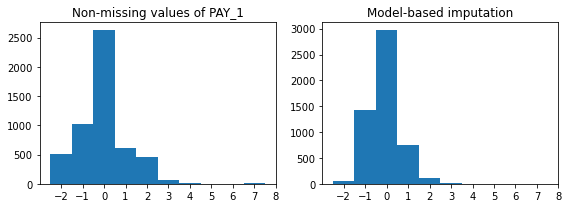

In [47]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

In [48]:
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

In [49]:
rf_impute = RandomForestClassifier(n_estimators=100, max_depth=12)

In [50]:
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12)

In [51]:
df_fill_pay_1_model = df_missing_pay_1.copy()

In [52]:
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [53]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

In [54]:
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [55]:
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

-2      30
-1     763
 0    1715
 1     438
 2      64
 3       7
 4       2
 6       1
 8       1
Name: PAY_1, dtype: int64

In [56]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
    test_size=0.2, random_state=24)

In [57]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

In [58]:
rf

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [59]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
cv=k_folds, n_jobs=-1, verbose=1,
    return_train_score=True, return_estimator=True,
    error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   20.7s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   20.8s finished


In [60]:
np.mean(imputation_compare_cv['test_score'])

0.7726757126815554

In [61]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)

In [62]:
df_fill_pay_1_model['PAY_1'].unique()

array([0], dtype=int64)

In [63]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [64]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [65]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
cv=k_folds, n_jobs=-1, verbose=1,
    return_train_score=True, return_estimator=True,
    error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   22.2s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.3s finished


In [66]:
np.mean(imputation_compare_cv['test_score'])

0.772866246168149

In [67]:
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.5s finished


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [68]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])

0.7696243835824927

In [70]:
X_all = np.concatenate((X_train_all, X_test_all), axis=0)
y_all = np.concatenate((y_train_all, y_test_all), axis=0)

In [87]:
y_all.shape

(29685,)

In [86]:
X_all.shape

(29685, 17)

In [105]:
app_array = np.hstack((X_all,y_all[:,None]))

In [114]:
df_app = pd.DataFrame(app_array)

In [119]:
df_app1=df_app.rename(columns={0:'LIMIT_BAL',
                        1:'EDUCATION',
                        2:'MARRIAGE',
                        3:'AGE',
                        4:'PAY_1',
                        5:'BILL_AMT1',
                        6:'BILL_AMT2',
                        7:'BILL_AMT3',
                        8:'BILL_AMT4',
                        9:'BILL_AMT5',
                        10:'BILL_AMT6',
                        11:'PAY_AMT1',
                        12:'PAY_AMT2',
                        13:'PAY_AMT3',
                        14:'PAY_AMT4',
                        15:'PAY_AMT5'})

In [120]:
df_app2 = df_app1.rename(columns={16:'PAY_AMT6',17:'DEFAULT'})

In [121]:
df_app2.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,120000,2,2,24,0,34670,35606,27065,25948,11884,3107,2033,1200,0,0,3107,8542,1
1,190000,1,1,39,2,171462,163148,165281,173231,132145,146854,0,10000,15000,10091,20000,10000,1
2,420000,2,1,37,-1,3823,149793,56611,77406,79316,73995,150298,10617,25000,3034,3012,5012,0
3,30000,1,2,36,2,24796,26088,27032,26723,23143,17106,2000,1804,2014,1521,1204,1500,1
4,120000,3,1,37,0,19821,20836,23562,22890,23189,23521,1651,3377,0,976,855,1011,0


In [123]:
df_app2.to_csv('cleaned_appdata.csv', index=False)

In [71]:
rf.fit(X_all, y_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.1s finished


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [72]:
thresholds = np.linspace(0, 1, 101)

In [73]:
df[features_response[:-1]].columns[5]

'BILL_AMT1'

In [74]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default

51601.7433479286

In [75]:
cost_per_counseling = 7500

In [76]:
effectiveness = 0.70

In [77]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)
savings_based_on_balances = np.empty_like(thresholds)

In [78]:
counter = 0
for threshold in thresholds:
    pos_pred = y_test_all_predict_proba[:,1]>threshold
    n_pos_pred[counter] = sum(pos_pred)
    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness
    counter += 1

In [79]:
net_savings = savings_of_all_counselings - cost_of_all_counselings

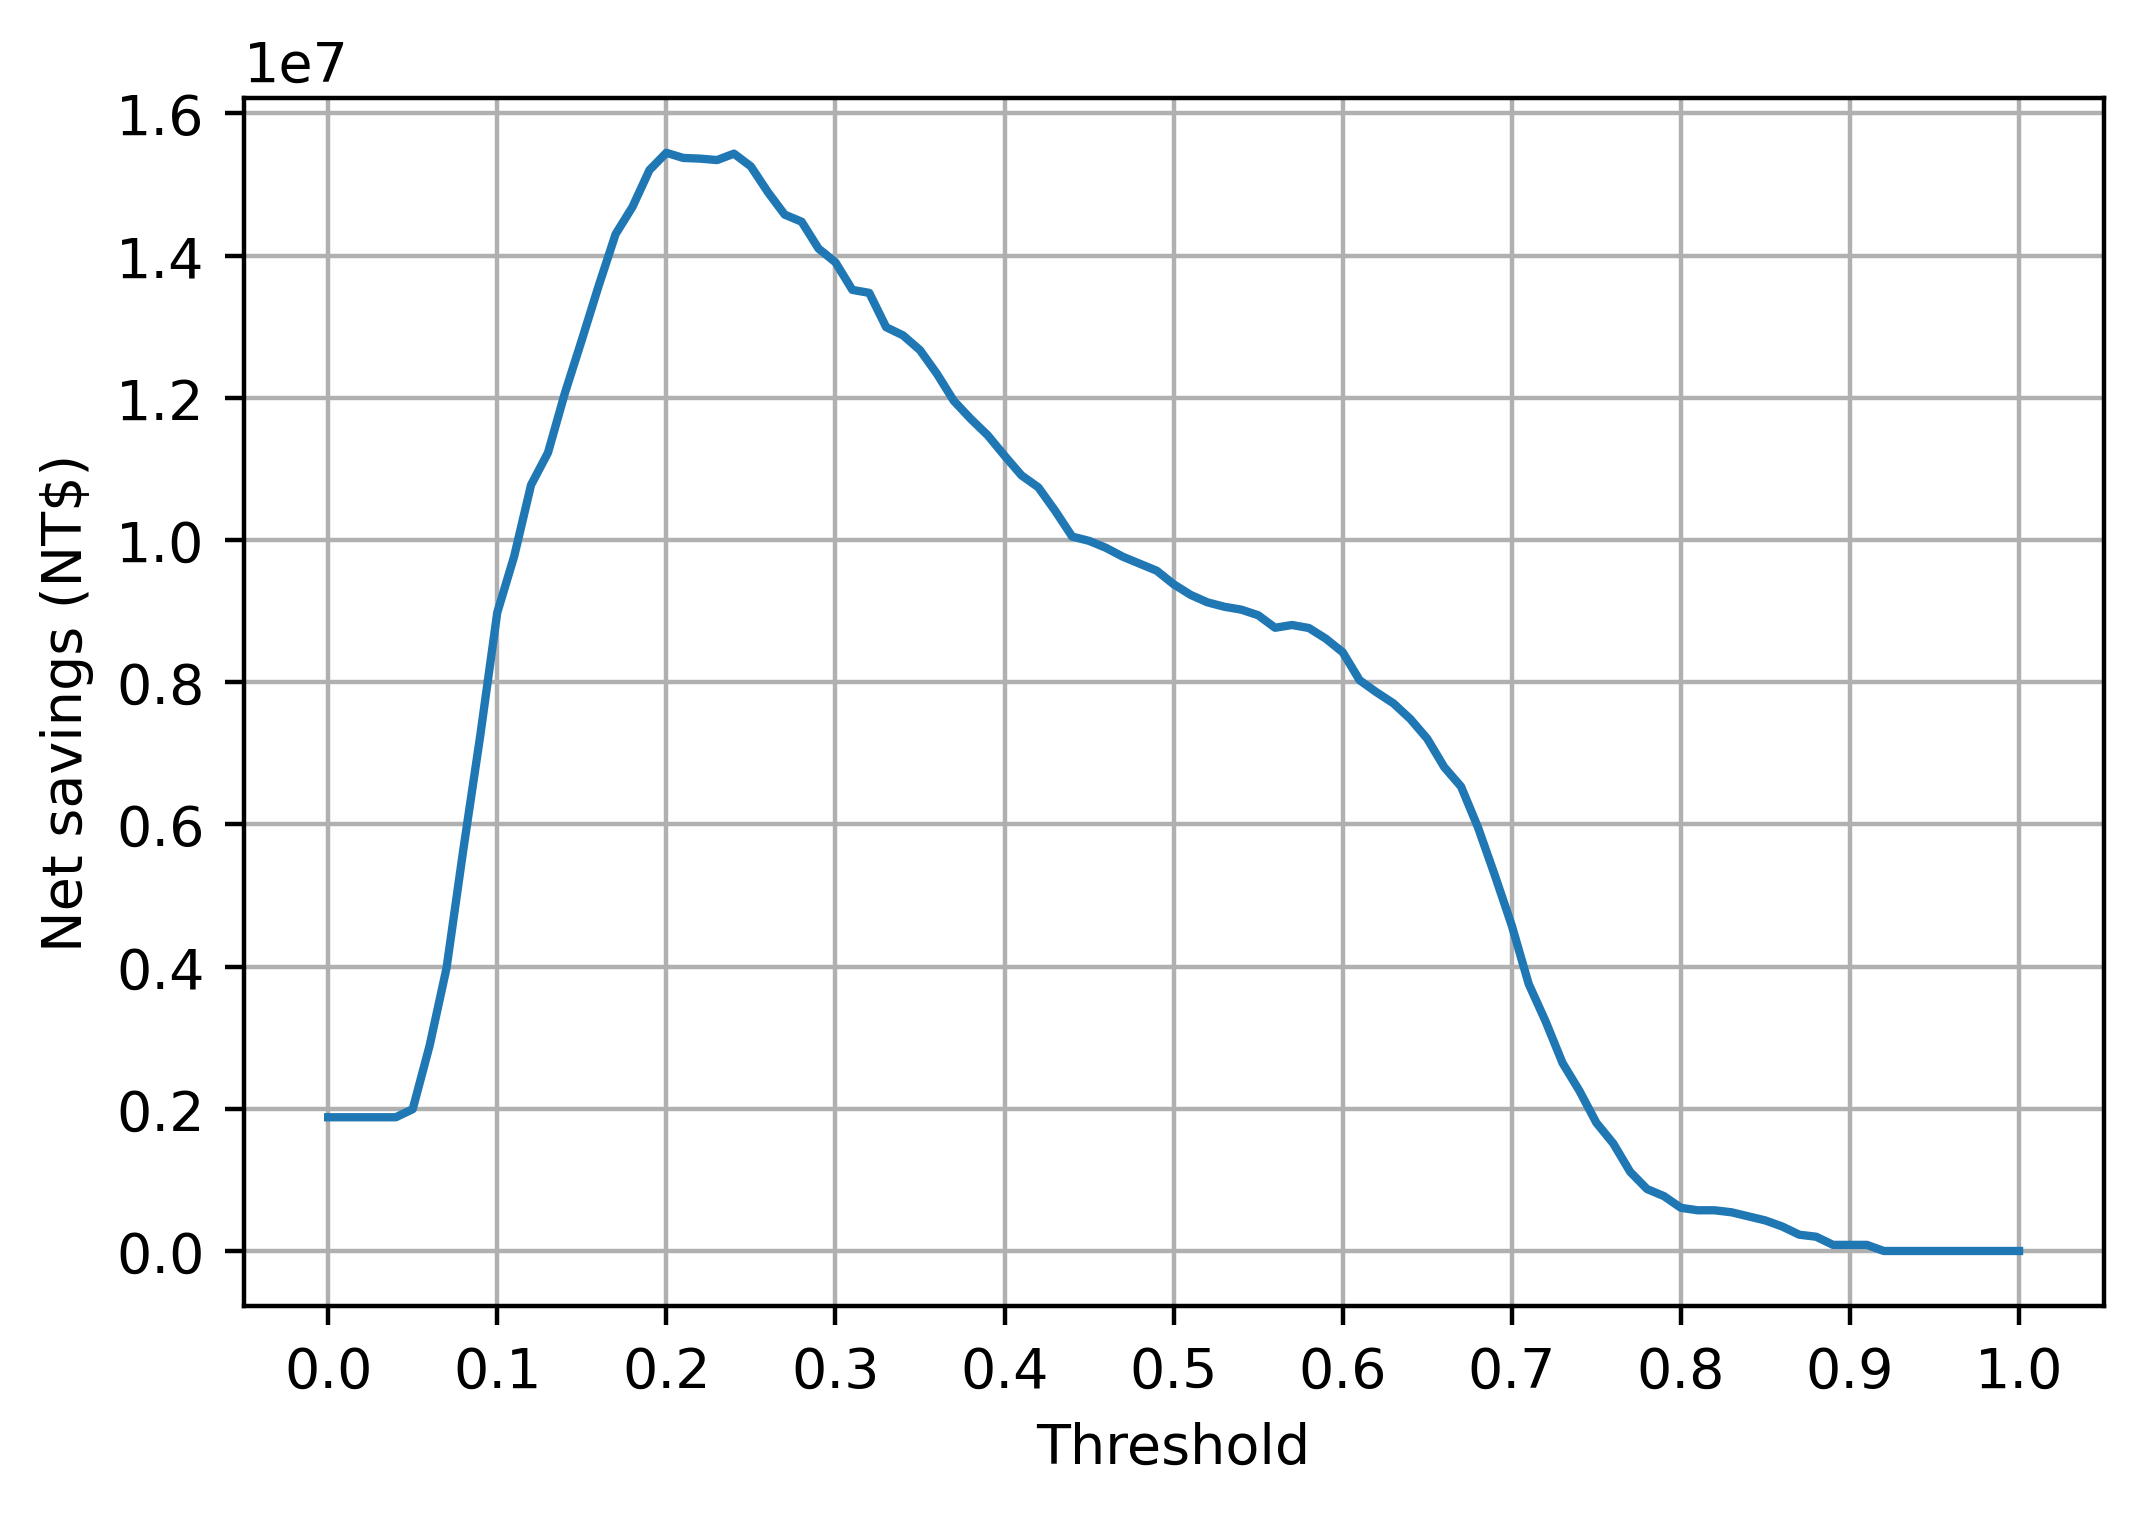

In [80]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [81]:
max_savings_ix = np.argmax(net_savings)

In [82]:
thresholds[max_savings_ix]

0.2

In [83]:
net_savings[max_savings_ix]

15446325.35991916

Text(0, 0.5, 'Number of accounts')

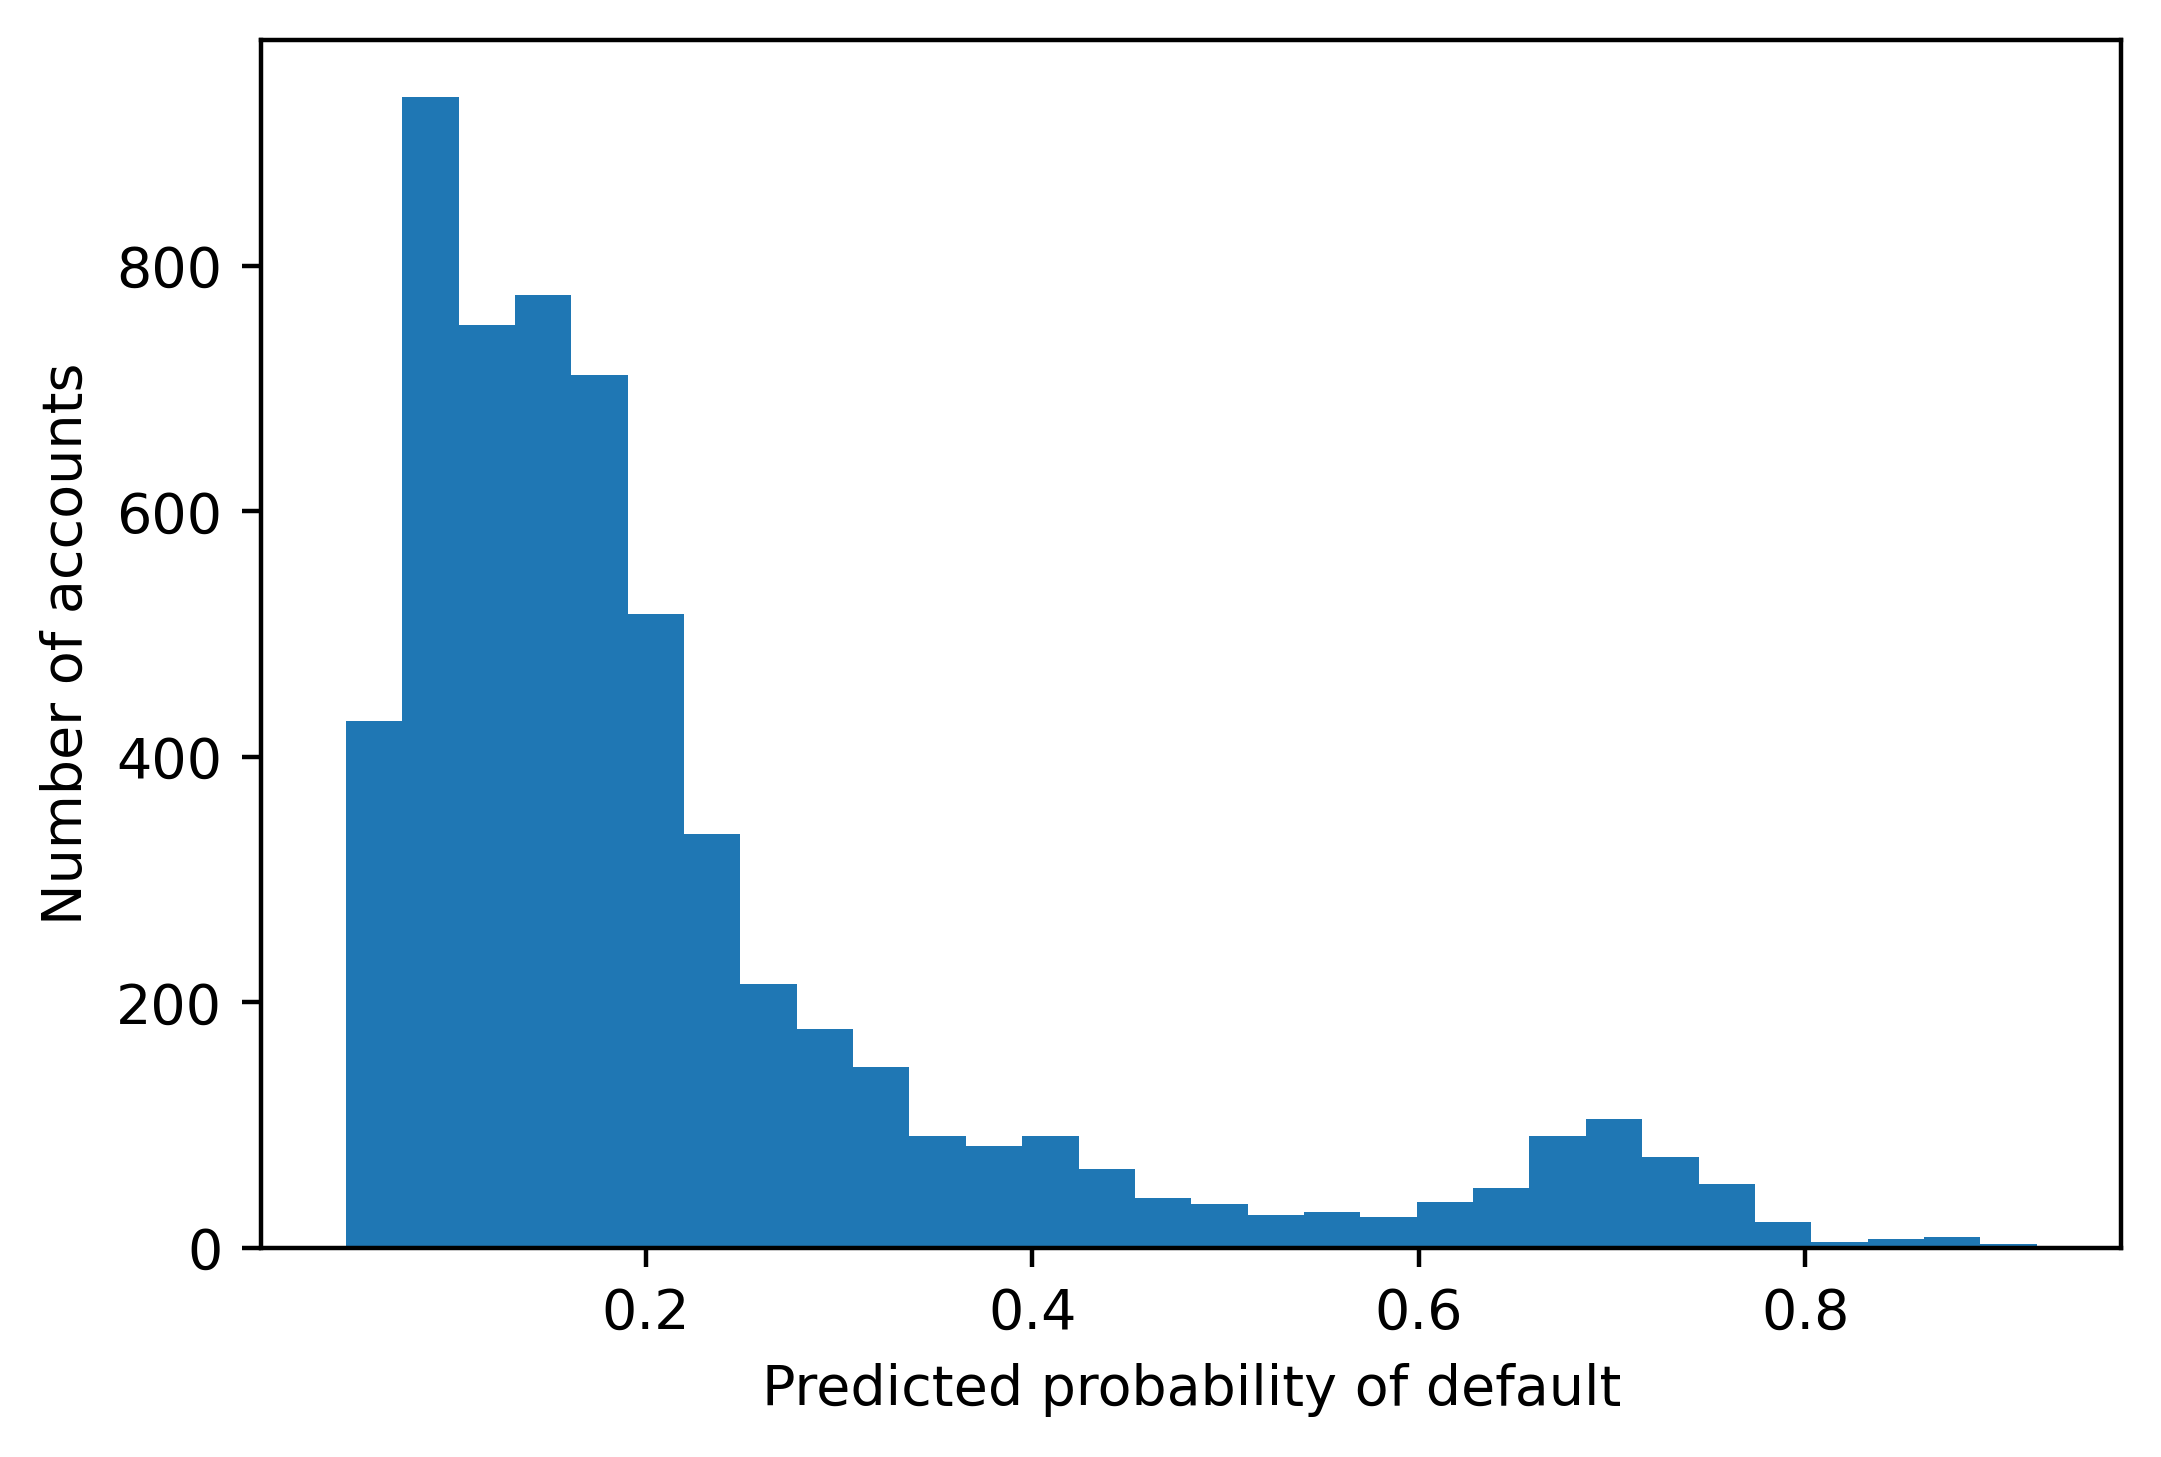

In [84]:
plt.hist(y_test_all_predict_proba[:,1], bins=30)
plt.xlabel('Predicted probability of default')
plt.ylabel('Number of accounts')

In [124]:
import joblib
joblib.dump(rf, "default.pkl")

['default.pkl']

In [126]:
li=df_app2['LIMIT_BAL']

In [127]:
li.max()

1000000

In [128]:
li.min()

10000

In [129]:
df_app2.describe()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,2.968500e+04,29685.000000,29685.000000,29685.000000,29685.000000,2.968500e+04,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000
mean,167519.948796,1.842109,1.557655,35.481354,-0.015968,51184.178103,49140.322553,4.699076e+04,43245.439279,40307.628263,38888.682095,5672.886812,5.917545e+03,5229.295570,4826.770827,4805.203840,5219.023008,0.221054
std,129716.478534,0.744222,0.521295,9.212199,1.067908,73578.295929,71091.014997,6.930111e+04,64276.899483,60787.204536,59588.111810,16616.452239,2.310628e+04,17650.360969,15607.256127,15311.798994,17798.365183,0.414964
min,10000.000000,1.000000,1.000000,21.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,28.000000,-1.000000,3560.000000,2984.000000,2.663000e+03,2329.000000,1760.000000,1257.000000,1000.000000,8.320000e+02,390.000000,296.000000,250.000000,115.000000,0.000000
50%,140000.000000,2.000000,2.000000,34.000000,0.000000,22381.000000,21197.000000,2.010700e+04,19040.000000,18106.000000,17067.000000,2100.000000,2.008000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,41.000000,0.000000,67028.000000,63992.000000,6.016700e+04,54515.000000,50244.000000,49252.000000,5007.000000,5.000000e+03,4508.000000,4015.000000,4041.000000,4000.000000,0.000000
max,1000000.000000,4.000000,3.000000,79.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000
